# Calculating the Radius from transit depth

You Belong With Me
****

Importing Modules

In [1]:
import astropy.constants as const
import Gridingtons as grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from WhatisLife import Rotator

In [2]:
%matplotlib notebook
π = np.pi
Colour = plt.style.use('tableau-colorblind10')

In [3]:
def ScreamExtractor(File, Sep=','):
    FILENAME = pd.read_csv(f'{File}', sep=Sep)
    return FILENAME

In [4]:
Directory = 'C:/Users/georg/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
HoVanData = ScreamExtractor(f'{Directory}/Sorted Data/Planets/Final Planets.csv')
GaiaDatat = ScreamExtractor(f'{Directory}/BASTA/Input/Gaia.txt', '\t')
GaiaData2t = ScreamExtractor(f'{Directory}/Sorted Data/Stars/Gaia All Stars.csv')
BASTAData = ScreamExtractor(f'{Directory}/BASTA/Output/GaiaResultsFinal.ascii', '\t')

In [5]:
len(HoVanData)

899

In [6]:
Object = BASTAData
for f in range(len(Object)):
    if str(Object['radPhot'][f]) == 'nan':
        BASTAData = BASTAData.drop(f)

In [7]:
GaiaData = pd.DataFrame()
GaiaData2 = pd.DataFrame()
for g in range(len(BASTAData)):
    try:
        Line = GaiaDatat[GaiaDatat['# ID'] == BASTAData['starid'][g]]
        GaiaData = pd.concat([GaiaData, Line], ignore_index=True)
    except:
        continue

    try:
        Line = GaiaData2t[GaiaData2t['Gaia DR3 ID'] == BASTAData['starid'][g]]
        GaiaData2 = pd.concat([GaiaData2, Line], ignore_index=True)
    except:
        continue
del GaiaDatat, GaiaData2t

In [8]:
def PlanetRadiusErrors(Ratio, Radius, RatioError, RadiusError):
    Error = np.sqrt((Ratio*RadiusError)**2 + (Radius*RatioError)**2)*const.R_sun/const.R_earth
    return Error

In [9]:
def PlanetRadiusFinder(Planets, Stars, BASTAfication='Post'):
    if BASTAfication == 'Pre':
        ID = 'Gaia DR3 ID'
        Radii = 'Radius'
        Radiierrp = 'Rad pe'
        Radiierrm = 'Rad me'
    else:
        ID = 'starid'
        Radii = 'radPhot'
        Radiierrp = 'radPhot_errp'
        Radiierrm = 'radPhot_errm'
    
    Period = []
    PlanetRadius = []
    PlanetRadiuserrp = []
    PlanetRadiuserrm = []
    for n in range(len(Planets)):
        try:
            Index = Stars[Stars[ID] == Planets['Host Gaia DR3 ID'][n]].index[0]
            Radius = Planets['PSR'][n]*Stars[Radii][Index]*const.R_sun/const.R_earth
            if Radius < 4:
                Period.append(Planets['P'][n])
                PlanetRadius.append(Radius)

                PlanetRadiuserrp.append(PlanetRadiusErrors(Planets['PSR'][n], Stars[Radii][Index],
                                                           Planets['PSR pme'][n], Stars[Radiierrp][Index]))
                PlanetRadiuserrm.append(PlanetRadiusErrors(Planets['PSR'][n], Stars[Radii][Index],
                                                           Planets['PSR pme'][n], Stars[Radiierrm][Index]))
        except:
            continue
    return Period, PlanetRadius, [PlanetRadiuserrp, PlanetRadiuserrm]

In [10]:
PeriodBASTA, RadiusBASTA, RadiusBASTAerr = PlanetRadiusFinder(HoVanData, BASTAData)
PeriodGaia, RadiusGaia, RadiusGaiaerr = PlanetRadiusFinder(HoVanData, GaiaData2, 'Pre')

In [11]:
len(PeriodBASTA)

566

In [12]:
len(PeriodBASTA)

566

In [13]:
def Gradienter(XAxis, YAxis, m, X=10):
    NewX = np.linspace(10, 10, len(XAxis))
    NewY = 10**(m*(X-XAxis)+YAxis)
    return NewX, NewY

<IPython.core.display.Javascript object>


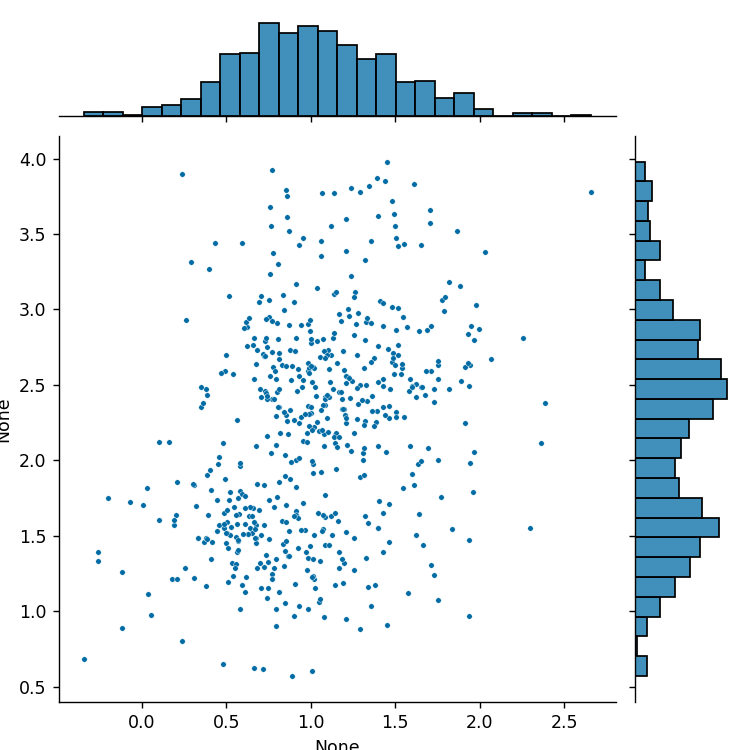

In [14]:
Title = 'Radius Valley plot for Gaia Stars and VanHo Planets'
'''
plt.figure()
plt.errorbar(PeriodGaia, RadiusGaia, yerr=RadiusGaiaerr,
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia')
plt.errorbar(PeriodBASTA, RadiusBASTA, yerr=RadiusBASTAerr,
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia)')
plt.xscale('log')
plt.xlabel('log(Orbital Period/Days)', fontsize=12)
plt.ylabel('$R/R_{\oplus}$', fontsize=12)
plt.title(Title, fontsize=15)
plt.legend()
plt.show()
'''
#sns.jointplot(x=np.log10(PeriodGaia), y=np.array(RadiusGaia), joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
sns.jointplot(x=np.log10(PeriodBASTA), y=np.array(RadiusBASTA), joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
plt.show()

In [15]:
Centre = [(min(PeriodBASTA)+max(PeriodBASTA))/2,(min(RadiusBASTA)+max(RadiusBASTA))/2]
Angles = π/400
Rotator(PeriodBASTA, RadiusBASTA, Centre, Angles)

UnitConversionError: Can only apply 'add' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

In [16]:
len(PeriodBASTA)

566

In [17]:
x = np.linspace(min(PeriodBASTA), max(PeriodBASTA), 2)
m = -0.11
c1 = 0.37
y1 = 10**(m*np.log10(x) + c1)

<IPython.core.display.Javascript object>


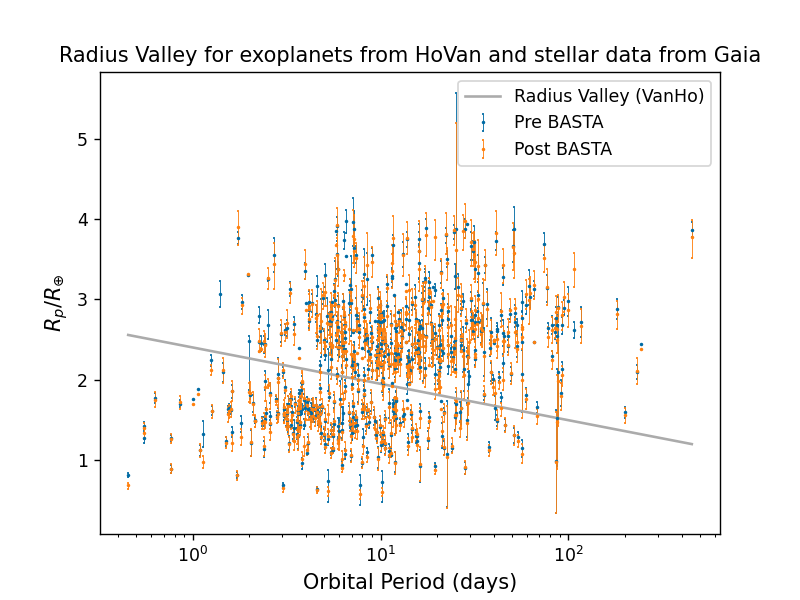

In [18]:
Title='Radius Valley for exoplanets from HoVan and stellar data from Gaia'

plt.figure()
plt.errorbar(PeriodGaia, RadiusGaia, yerr=RadiusGaiaerr, elinewidth=0.5,
             capsize=0.5, fmt='.', color=Colour, markersize=2, label='Pre BASTA')
plt.errorbar(PeriodBASTA, RadiusBASTA, yerr=RadiusBASTAerr, elinewidth=0.5,
             capsize=0.5, fmt='.', color=Colour, markersize=2, label='Post BASTA')
plt.plot(x, y1, color=Colour, label='Radius Valley (VanHo)')
plt.xlabel('Orbital Period (days)', fontsize=12)
plt.ylabel(r'$R_p/R_{\oplus}$', fontsize=12)
plt.title(Title, fontsize=12)
plt.xscale('log')
plt.legend()
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/Final Stars - {Title}')

In [19]:
SolarTemp = 5772
def LuminosityErrors(Radius, Teff, RadiusError, TeffError):
    Error = 2*Radius*Teff**3/SolarTemp**4*np.sqrt(Teff**2*RadiusError**2 + 4*Radius**2*TeffError**2)
    return Error

In [20]:
GaiaData2['Rad pe'] += 0.035*GaiaData2['Radius']
GaiaData2['Rad me'] += 0.035*GaiaData2['Radius']

In [21]:
LuminosityGaia = GaiaData2['Radius']**2*(GaiaData2['Teff']/SolarTemp)**4
LuminosityBASTA = BASTAData['radPhot']**2*(BASTAData['Teff']/SolarTemp)**4
LuminosityGaiaerrp = LuminosityErrors(GaiaData2['Radius'], GaiaData['Teff'], 
                                       GaiaData2['Rad pe'], GaiaData['Teff-err'])
LuminosityGaiaerrm = LuminosityErrors(GaiaData2['Radius'], GaiaData['Teff'], 
                                       GaiaData2['Rad me'], GaiaData['Teff-err'])
LuminosityBASTAerrp = LuminosityErrors(BASTAData['radPhot'], BASTAData['Teff'], 
                                       BASTAData['radPhot_errp'], BASTAData['Teff_errp'])
LuminosityBASTAerrm = LuminosityErrors(BASTAData['radPhot'], BASTAData['Teff'], 
                                       BASTAData['radPhot_errm'], BASTAData['Teff_errm'])

<IPython.core.display.Javascript object>


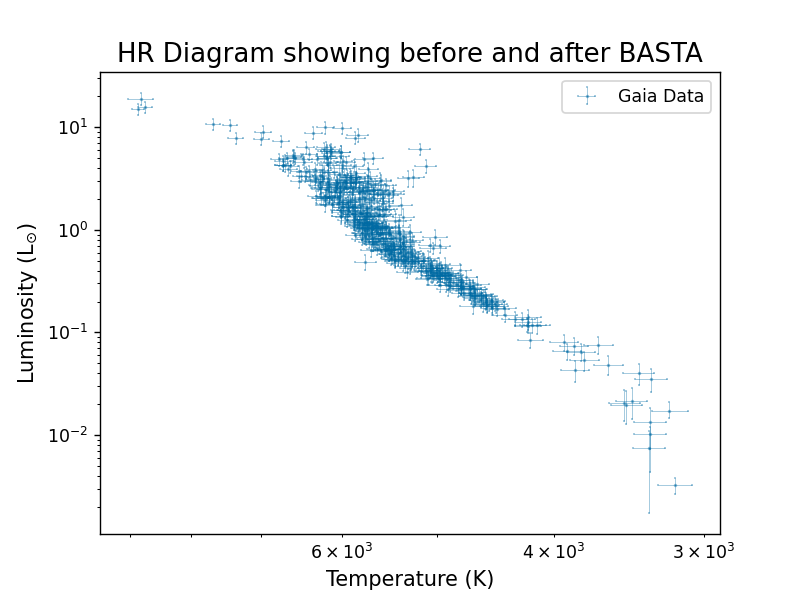

In [26]:
Title = 'HR Diagram showing before and after BASTA'

plt.figure()
plt.errorbar(GaiaData2['Teff'], LuminosityGaia, xerr=GaiaData['Teff-err'],
             yerr=[LuminosityGaiaerrp, LuminosityGaiaerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia Data', alpha=0.4)
'''plt.errorbar(BASTAData['Teff'], LuminosityBASTA, xerr=[BASTAData['Teff_errp'], BASTAData['Teff_errm']],
             yerr=[LuminosityBASTAerrp, LuminosityBASTAerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia) Data', alpha=1)'''
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Luminosity (L$_{\odot}$)', fontsize=12)
plt.title(Title, fontsize=15)
#plt.xlim(8000, 4000)
#plt.ylim(0.01, 30)
plt.legend()
plt.show()
plt.savefig(f'{Directory}/Plots/Report Plots/Final Stars - {Title}')

In [ ]:
Title = 'HR Diagram showing Radius before and after BASTA'

plt.figure()
plt.errorbar(GaiaData2['Teff'], GaiaData2['Radius'], xerr=GaiaData['Teff-err'],
             yerr=[GaiaData2['Rad pe']+0.035/GaiaData2['Radius'], GaiaData2['Rad me']+0.035/GaiaData2['Radius']],
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia Data', alpha=0.4)
plt.errorbar(BASTAData['Teff'], BASTAData['radPhot'], xerr=[BASTAData['Teff_errp'], BASTAData['Teff_errm']],
             yerr=[BASTAData['radPhot_errp'], BASTAData['radPhot_errm']], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia) Data', alpha=1)
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Radius (R$_{\odot}$)', fontsize=12)
plt.title(Title, fontsize=15)
#plt.xlim(8000, 4000)
plt.ylim(0.2, 5)
plt.legend()
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All - {Title}')

In [ ]:
np.median(PercentageError1.dropna())

In [ ]:
PercentageError1 = (GaiaData2['Rad pe']+GaiaData2['Rad me'])/2/GaiaData2['Radius']*100+3.5
PercentageError2 = (BASTAData['radPhot_errp']+BASTAData['radPhot_errm'])/2/BASTAData['radPhot']*100
Median1 = np.median(PercentageError1.dropna())
Median2 = np.median(PercentageError2)


Title = r'KDE of % Uncertainty in Radius before and after BASTA '
plt.figure()
ax = sns.kdeplot(data=PercentageError1, label='Pre BASTA')
sns.kdeplot(data=PercentageError2, label='Post BASTA')
ax.axvline(Median1, color='blue', linestyle='--', label=f'Pre-Median: {np.round(Median1, 2)}')
ax.axvline(Median2, color='orange', linestyle='--', label=f'Post-Median: {np.round(Median2, 2)}')
plt.xlabel(r'% Uncertainty in Radius')
plt.title(Title)
plt.xlim(0, 15)
plt.legend()
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/Final Stars - {Title}')

In [ ]:
Title = r'KDE of Radius before and after BASTA '
plt.figure()
ax = sns.kdeplot(data=GaiaData2['Radius'], label='Pre BASTA')
sns.kdeplot(data=BASTAData['radPhot'], label='Post BASTA')
plt.xlabel(r'Radius')
plt.title(Title)
plt.legend()
plt.xlim(0, 5)
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All Stars - {Title}')

In [ ]:
Title = 'Radius % Uncertainty change'

plt.figure()
plt.plot(BASTAData['radPhot'], PercentageError2, '.', markersize=2)
plt.xlabel('Radius (R$_{\odot}$)')
plt.ylabel('% Uncertainty in Radius')
plt.title(Title)
plt.ylim(0, 20)
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All Stars - {Title}')

You tatty git